<a href="https://colab.research.google.com/github/Hilly12/masters-code/blob/main/CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Privacy and Fairness - CelebA

## Setup

In [1]:
!pip install opacus

     |████████████████████████████████| 175 kB 15.6 MB/s 


In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager
from torchvision import datasets, transforms, models
from tqdm import tqdm
from collections import OrderedDict
from scipy.stats import wasserstein_distance
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
drive.mount('/content/gdrive')

data_root = "data/celeba"

if not os.path.exists(data_root):
    os.makedirs(data_root)

!cp gdrive/My\ Drive/Datasets/list_attr_celeba.txt "$data_root"
!unzip -q -d "$data_root" gdrive/My\ Drive/Datasets/img_align_celeba.zip

Mounted at /content/gdrive


## Data Loading

In [11]:
mean = torch.Tensor([0.5, 0.5, 0.5])
std = torch.Tensor([0.5, 0.5, 0.5])

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def denorm(x, channels=None, w=None, h=None, resize=False):
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataset = datasets.ImageFolder(root=data_root, transform=transform)
df_attr = pd.read_csv(f"{data_root}/list_attr_celeba.txt", delim_whitespace=True, header=1)
df_attr = ((df_attr + 1) / 2)
df_attr.index = df_attr.index.set_names(["Image"])
df_attr.reset_index(inplace=True)
df_attr.head()

,Image,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,000002.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,000003.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,000004.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
4,000005.jpg,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Original
Males: 84434 Females: 118165
Total: 202599
After Downsampling (30000)
Males: 3000 Females: 27000
Total: 30000


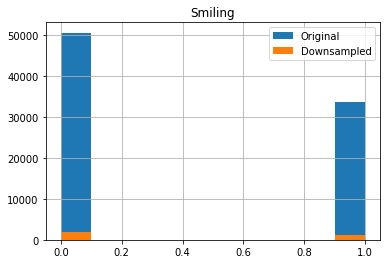

In [12]:
n_samples = 30000
task = "Smiling"

target_split = 0.1
n_male = int(target_split * n_samples)
n_female = int((1 - target_split) * n_samples)

orig_m_mask = df_attr["Male"] == 1
orig_f_mask = df_attr["Male"] == 0

m_idxs = np.random.choice(df_attr[orig_m_mask].index, n_male, replace=False)
f_idxs = np.random.choice(df_attr[orig_f_mask].index, n_female, replace=False)
idxs = np.concatenate((m_idxs, f_idxs))
np.random.shuffle(idxs)
df = df_attr[df_attr.index.isin(idxs)].copy()

m_mask = df["Male"] == 1
f_mask = df["Male"] == 0

print("Original")
print(f"Males: {len(df_attr[orig_m_mask][task])} Females: {len(df_attr[orig_f_mask][task])}")
print(f"Total: {len(df_attr)}")
print(f"After Downsampling ({len(idxs)})")
print(f"Males: {len(df[m_mask][task])} Females: {len(df[f_mask][task])}")
print(f"Total: {len(df)}")

df_attr[orig_m_mask][task].hist()
df[m_mask][task].hist()
plt.title(task)
plt.legend(["Original", "Downsampled"])
plt.show()

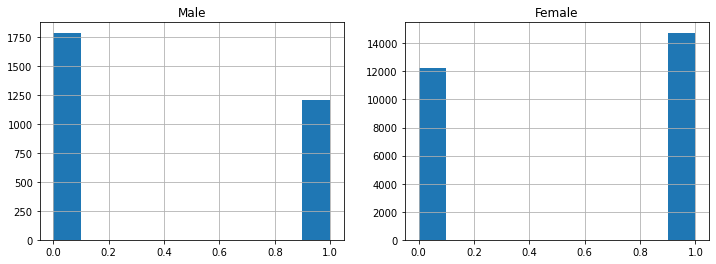

In [13]:
ax1, ax2 = plt.subplots(1, 2, figsize=(12, 4))[1]
df[m_mask][task].hist(ax=ax1)
df[f_mask][task].hist(ax=ax2)
ax1.set_title("Male")
ax2.set_title("Female")
plt.show()

In [14]:
data = []
for idx in tqdm(idxs):
    img = dataset[idx][0]
    label = torch.Tensor([df_attr[task][idx]]).long().squeeze()
    data.append([img, label])

100%|██████████| 30000/30000 [00:43<00:00, 690.34it/s]


In [16]:
logical_batch_size = 512
max_physical_batch_size = 128
test_split = 0.2

n = len(data)
n_test = int(test_split * n)
test_dataset = data[:n_test]
train_dataset = data[n_test:]

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=logical_batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=logical_batch_size,
    shuffle=False
)

tensor(1)


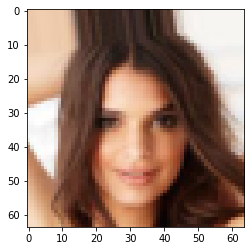

In [17]:
imgs, labels = next(iter(train_loader))
idx = 0
print(labels[idx])
show(denorm(imgs[idx]))

## Training the Models

### Helpers

In [18]:
# Helpers

def remove_hooks(model):
    model._backward_hooks = OrderedDict()
    model._forward_hooks = OrderedDict()
    model._forward_pre_hooks = OrderedDict()
    for child in model.children():
        remove_hooks(child)

def save_model(model, name):
    path = "/content/gdrive/MyDrive/Thesis/Models/"
    data = next(iter(train_loader))[0]
    remove_hooks(model)

    with torch.no_grad():
        torch.jit.save(torch.jit.trace(model.cpu(), (data), check_trace=False), path + f"{name}.pth")

def save_metrics(metrics, name):
    path = "/content/gdrive/MyDrive/Thesis/Metrics/"

    with open(path + f"{name}.json", 'w') as f:
        json.dump(metrics, f)
        f.close()

def load_model(name):
    path = "/content/gdrive/MyDrive/Thesis/Models/"

    return torch.jit.load(path + f"{name}.pth")

def load_metrics(name):
    path = "/content/gdrive/MyDrive/Thesis/Metrics/"

    with open(path + f"{name}.json", 'r') as f:
        metrics = json.load(f)
        f.close()

    return metrics

def evaluate(model, test_loader, return_outputs=False):
    model.eval()

    correct = 0
    total = 0
    pred_list = []
    raw_outputs = []
    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target

            output = model(images).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_list.append(preds)
            raw_outputs.append(output)

    acc = correct / len(test_loader.dataset)

    print(f"Test Accuracy: {acc * 100:.6f}")

    if return_outputs:
        return np.concatenate(pred_list), np.concatenate(raw_outputs)

    return np.concatenate(pred_list)

### Training

In [19]:
def train_vanilla(train_loader, epochs, pretrained=False):
    if pretrained:
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(512, 2)
    else:
        model = models.resnet18(num_classes=2)

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters())

    model.train()
    losses = []
    accuracies = []

    for epoch in range(epochs):
        epoch_losses = []
        epoch_accuracies = []

        for i, (images, target) in enumerate(tqdm(train_loader)):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            acc = (preds == labels).mean()

            epoch_losses.append(loss.item())
            epoch_accuracies.append(acc)

            loss.backward()
            optimizer.step()

        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(epoch_losses):.6f} "
            f"Acc: {np.mean(epoch_accuracies) * 100:.6f} "
        )

        losses.extend(epoch_losses)
        accuracies.extend(epoch_accuracies)

    metrics = { "loss": losses, "accuracy": accuracies }
    return model, metrics


def train_dpsgd(train_loader, max_grad_norm, epsilon, delta, epochs, pretrained=False):
    if pretrained:
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(512, 2)
    else:
        model = models.resnet18(num_classes=2)

    model = ModuleValidator.fix(model)
    assert ModuleValidator.validate(model, strict=False) == []

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters())
    privacy_engine = PrivacyEngine()

    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=epochs,
        target_epsilon=epsilon,
        target_delta=delta,
        max_grad_norm=max_grad_norm,
    )
    
    model.train()
    losses = []
    accuracies = []

    for epoch in range(epochs):
        epoch_losses = []
        epoch_accuracies = []
        
        with BatchMemoryManager(
            data_loader=train_loader, 
            max_physical_batch_size=max_physical_batch_size, 
            optimizer=optimizer
        ) as memory_safe_data_loader:

            for i, (images, target) in enumerate(tqdm(memory_safe_data_loader)):   
                optimizer.zero_grad()
                images = images.to(device)
                target = target.to(device)

                output = model(images)
                loss = criterion(output, target)

                preds = np.argmax(output.detach().cpu().numpy(), axis=1)
                labels = target.detach().cpu().numpy()

                acc = (preds == labels).mean()

                epoch_losses.append(loss.item())
                epoch_accuracies.append(acc)

                loss.backward()
                optimizer.step()

            epsilon = privacy_engine.get_epsilon(delta)

        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(epoch_losses):.6f} "
            f"Acc: {np.mean(epoch_accuracies) * 100:.6f} "
            f"(ε = {epsilon:.2f}, δ = {delta})"
        )

        losses.extend(epoch_losses)
        accuracies.extend(epoch_accuracies)

    metrics = { "loss": losses, "accuracy": accuracies }
    return model, metrics

In [21]:
model_vanilla, metrics_vanilla = train_vanilla(
    train_loader=train_loader,
    epochs=5,
    pretrained=True
)

100%|██████████| 47/47 [00:22<00:00,  2.07it/s]


Train Epoch: 1 Loss: 0.399570 Acc: 84.432585 


100%|██████████| 47/47 [00:23<00:00,  2.04it/s]


Train Epoch: 2 Loss: 0.179058 Acc: 92.343038 


100%|██████████| 47/47 [00:23<00:00,  2.04it/s]


Train Epoch: 3 Loss: 0.158389 Acc: 93.047112 


100%|██████████| 47/47 [00:23<00:00,  2.03it/s]


Train Epoch: 4 Loss: 0.139149 Acc: 93.994586 


100%|██████████| 47/47 [00:23<00:00,  2.02it/s]

Train Epoch: 5 Loss: 0.110942 Acc: 95.082756 


In [22]:
evaluate(model_vanilla, test_loader);

Test Accuracy: 91.883333


In [23]:
id = f"m{len(df[m_mask]) / len(df):.2f}"

save_model(model_vanilla, f"Vanilla({id})")
save_metrics(metrics_vanilla, f"Vanilla({id})")

In [24]:
model_dpsgd, metrics_dpsgd = train_dpsgd(
    train_loader=train_loader,
    max_grad_norm=1.5,
    epsilon=1,
    delta=1e-5,
    epochs=5,
    pretrained=True
)

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:115: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."
  0%|          | 0/187 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing so

Train Epoch: 1 Loss: 1.297057 Acc: 53.763831 (ε = 0.54, δ = 1e-05)


210it [00:39,  5.32it/s]


Train Epoch: 2 Loss: 1.113940 Acc: 66.883023 (ε = 0.67, δ = 1e-05)


213it [00:39,  5.34it/s]


Train Epoch: 3 Loss: 0.732602 Acc: 80.297144 (ε = 0.78, δ = 1e-05)


204it [00:39,  5.14it/s]


Train Epoch: 4 Loss: 0.441019 Acc: 88.461520 (ε = 0.89, δ = 1e-05)


211it [00:39,  5.28it/s]

Train Epoch: 5 Loss: 0.429840 Acc: 89.053799 (ε = 0.99, δ = 1e-05)


In [25]:
evaluate(model_dpsgd, test_loader);

Test Accuracy: 90.300000


In [26]:
save_model(model_dpsgd, f"DPSGD({id})")
save_metrics(metrics_dpsgd, f"DPSGD({id})")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2359: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))


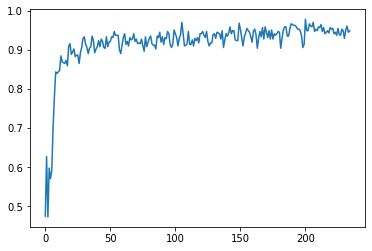

In [27]:
plt.plot(metrics_vanilla["accuracy"])
plt.show()

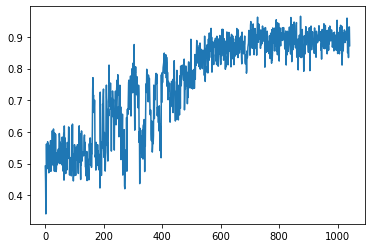

In [28]:
plt.plot(metrics_dpsgd["accuracy"])
plt.show()

## Fairness Analysis

In [29]:
id = "m0.10"

model_vanilla = load_model(f"Vanilla({id})")
model_dpsgd = load_model(f"DPSGD({id})")
metrics_vanilla = load_metrics(f"Vanilla({id})")
metrics_dpsgd = load_metrics(f"DPSGD({id})")

In [30]:
preds_vanilla, outs_vanilla = evaluate(model_vanilla.to(device), test_loader, return_outputs=True)
preds_dpsgd, outs_dpsgd = evaluate(model_dpsgd.to(device), test_loader, return_outputs=True)

Test Accuracy: 91.883333
Test Accuracy: 90.300000


In [31]:
df_test = df[:n_test].copy()
df_test.loc[:, "preds_vanilla"] = preds_vanilla.astype(float)
df_test.loc[:, "preds_dpsgd"] = preds_dpsgd.astype(float)
df_test.head()

,Image,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,preds_vanilla,preds_dpsgd
3,000004.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
11,000012.jpg,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17,000018.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
19,000020.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
21,000022.jpg,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [32]:
m_mask = df_test["Male"] == 1
f_mask = df_test["Male"] == 0
df_male = df_test[m_mask]
df_female = df_test[f_mask]

cm = confusion_matrix(df_male[task], df_male["preds_vanilla"])
tn, fp, fn, tp = cm.ravel()
print(f"Male TPR: {tp / (tp + fn)}")
print(f"Male FNR: {tn / (tn + fp)}")

cm = confusion_matrix(df_female[task], df_female["preds_vanilla"])
tn, fp, fn, tp = cm.ravel()
print(f"Female TPR: {tp / (tp + fn)}")
print(f"Female FNR: {tn / (tn + fp)}")

Male TPR: 0.5208333333333334
Male FNR: 0.47619047619047616
Female TPR: 0.546907574704656
Female FNR: 0.48198019801980196


In [33]:
cm = confusion_matrix(df_male[task], df_male["preds_dpsgd"])
tn, fp, fn, tp = cm.ravel()
print(f"Male TPR: {tp / (tp + fn)}")
print(f"Male FNR: {tn / (tn + fp)}")

cm = confusion_matrix(df_female[task], df_female["preds_dpsgd"])
tn, fp, fn, tp = cm.ravel()
print(f"Female TPR: {tp / (tp + fn)}")
print(f"Female FNR: {tn / (tn + fp)}")

Male TPR: 0.4666666666666667
Male FNR: 0.5294117647058824
Female TPR: 0.5055594162612925
Female FNR: 0.5144554455445545


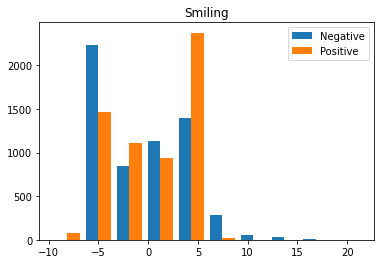

In [34]:
plt.hist(outs_vanilla)
plt.title(task)
plt.legend(["Negative", "Positive"])
plt.show()

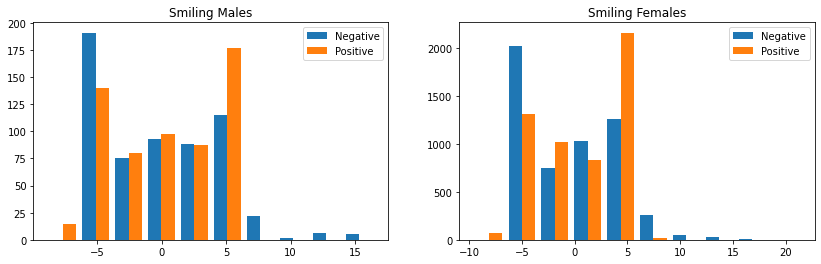

In [35]:
ax1, ax2 = plt.subplots(1, 2, figsize=(14, 4))[1]
ax1.hist(outs_vanilla[m_mask])
ax1.set_title(task + " Males")
ax1.legend(["Negative", "Positive"])
ax2.hist(outs_vanilla[f_mask])
ax2.set_title(task + " Females")
ax2.legend(["Negative", "Positive"])
plt.show()

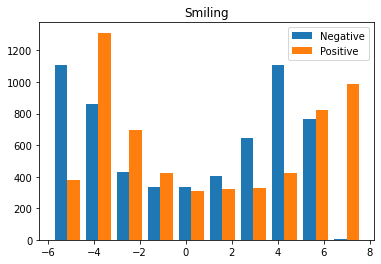

In [36]:
plt.hist(outs_dpsgd)
plt.title(task)
plt.legend(["Negative", "Positive"])
plt.show()

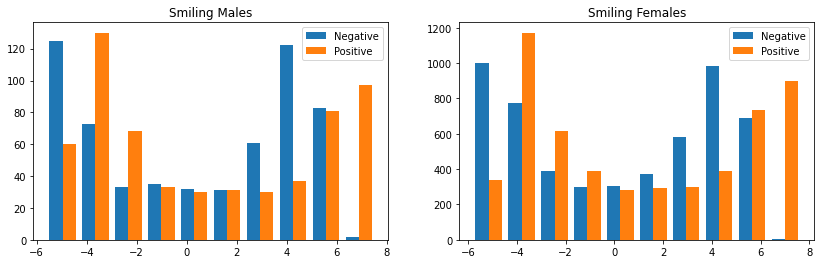

In [37]:
ax1, ax2 = plt.subplots(1, 2, figsize=(14, 4))[1]
ax1.hist(outs_dpsgd[m_mask])
ax1.set_title(task + " Males")
ax1.legend(["Negative", "Positive"])
ax2.hist(outs_dpsgd[f_mask])
ax2.set_title(task + " Females")
ax2.legend(["Negative", "Positive"])
plt.show()

In [ ]:
def emd(x, y):
    joint = np.concatenate((x, y))
    bin_edges = np.histogram_bin_edges(joint, bins="auto")
    bin_centers = np.mean([bin_edges[:-1], bin_edges[1:]], axis=0)

    hist_x = np.histogram(x, bins=bin_edges)[0]
    hist_y = np.histogram(y, bins=bin_edges)[0]
    hist_x = hist_x / hist_x.sum()
    hist_y = hist_y / hist_y.sum()

    return wasserstein_distance(bin_centers, bin_centers, u_weights=hist_x, v_weights=hist_y)

print("Wasserstein distance between output distributions for males and females")
print(f"Vanilla: {emd(outs_vanilla[m_mask][:, 0], outs_vanilla[f_mask][:, 0])}")
print(f"DPSGD: {emd(outs_dpsgd[m_mask][:, 0], outs_dpsgd[f_mask][:, 0])}")

Wasserstein distance between output distributions for males and females
Vanilla: 0.13199123181726988
DPSGD: 0.1139311785337816
